# VAE Model Evaluations -- Mainly Used For Debugging

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import axis, colorbar, imshow, show, figure, subplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline

import glob
import json

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras import backend as K                         #contains calls for tensor manipulations

Using TensorFlow backend.


In [2]:
print (tf.__version__)
print (keras.__version__)

2.1.0
2.3.1


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Define paths

In [4]:
from utils_vae_eval_paths import *

# What latent dimension and filter size are we using?:
latent_dim = 8

PATH = f'{kitkatdir}/saved_models'

# Get work direction for saving files:
TRAINED_MODELS = f'{PATH}/latent{latent_dim}'

In [5]:
save_plots = False

if save_plots == True:
    print ('Save figures in subfolder:', FIGURES_FOLDER)

# Load pre-traned model weights and other hyperparameters



### Load Images

In [6]:
print("[INFO] loading trained models and images...")

# load history from the trained model:
history = np.load(f'{TRAINED_MODELS}/HISTORY.npy', allow_pickle='TRUE').item()

# load training and testing images:
trainX   = np.load(f'{TRAINED_MODELS}/trainX.npy', allow_pickle='TRUE')       # training samples
valX     = np.load(f'{TRAINED_MODELS}/valX.npy', allow_pickle='TRUE')         # validation samples
testAllX = np.load(f'{TRAINED_MODELS}/testAllX.npy', allow_pickle='TRUE')     # all test samples
testAllY = np.load(f'{TRAINED_MODELS}/testAllY.npy', allow_pickle='TRUE')     # all test labels

print("          done")

[INFO] loading trained models and images...
          done


### Load Hyperparameters

In [7]:
txtfile = open(f'{TRAINED_MODELS}/notes.txt')

for line in txtfile:
    print(line)
    
# load some hyperparameters and data configurations automatic:
hyper_parameters = []
with open((f'{TRAINED_MODELS}/notes.txt'), 'r') as f:
    for l in f: 
        strnumbers = l.split(':')
        hyper_parameters.append(json.loads(strnumbers[1]))
        
no_epochs = hyper_parameters[0]
latent_dim = hyper_parameters[2]
img_width = hyper_parameters[4]
img_height = hyper_parameters[5]
num_channels = hyper_parameters[6]

Epochs: 2000 

Batch size: 256 

Latent dimension: 8 

Filter sizes: 32 

img_width: 128 

img_height: 128 

num_channels: 1


### Load VAE Architecture and its weights at final epoch

In [8]:
# improt architecture of encoder, decoder and VAE model:
from J8_VAE_model import *

In [9]:
""" load the final weight for the Encoder part """
encoder.load_weights(f'{TRAINED_MODELS}/ENCODER_WEIGHTS.h5')

""" load the final weight for the Encoder part """
decoder.load_weights(f'{TRAINED_MODELS}/DECODER_WEIGHTS.h5')

""" load the final weight for the VAE """
# Create a new model instance:
vae = create_model()
# Load the previously saved weights:
vae.load_weights(f'{TRAINED_MODELS}/VAE_WEIGHTS.h5', by_name=True)

/opt/conda/envs/python3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [10]:
from utils_VAE_AE import subsplit, delete_rand_items, KITKAT_get_counts

testNormalX, testNormalY = subsplit(testAllX , testAllY, class_label=0)

# Evaluate model

## Further Inspections of Results


### Latent Space

Inspect Learned Latent Space

In [11]:
# remember to use all data (bad and good sample in same array)
data = (testAllX, testAllY)

In [12]:
sns.reset_defaults()

# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/ (François Chollet).
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    
    labels = {0:   "normal",
              1:   "anomaly"} 
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    sc = ax.scatter(mu[:, 0], mu[:, 1], c=target_data, alpha=0.4, cmap='viridis')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    
    cbar = plt.colorbar(sc, ticks = range(2))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(2)])
    
    # produce a legend with the unique colors from the scatter
    #legend_ = ax.legend(*sc.legend_elements(),
    #                scatterpoints=3,
    #                loc="best", title="Classes")
    #ax.add_artist(legend_)
    
    plt.grid(False)
    plt.show()

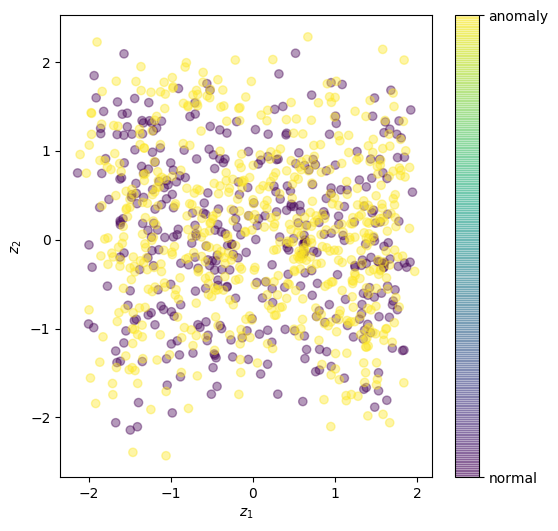

In [13]:
# display a 2D manifold plot of the digit classes in the latent space
viz_latent_space(encoder, data)

sns.set_style("darkgrid")

__Inspect variations__

Only normal test samples

In [14]:
testNormalEncodedX = encoder.predict(testNormalX)[2]
print (testNormalEncodedX.shape)

(400, 8)


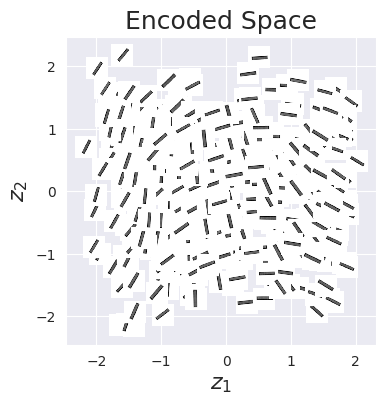

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

for x, xEnc in zip(testNormalX, testNormalEncodedX):
    imagebox = OffsetImage(x[:,:,0], cmap=cm.Greys_r, zoom=0.12)
    ab = AnnotationBbox(imagebox, [xEnc[0], xEnc[1]], frameon=False)                                  
    ax.add_artist(ab)
    
plt.xlim((testNormalEncodedX[:,0].min()-0.3, testNormalEncodedX[:,0].max()+0.3))
plt.ylim((testNormalEncodedX[:,1].min()-0.3, testNormalEncodedX[:,1].max()+0.3))
plt.xlabel('$z_1$', fontsize=16)
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encoded Space', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=10)

if (save_plots):
    plt.savefig(f"{FIGURES_FOLDER}/J2_encodedSpace.png", dpi=300, bbox_inches='tight')
plt.show()

#### Pair plot between normal and anomalies in latent space

From latent distribution

In [16]:
def pairplot_latent(encoder, data):
    # predict
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    
    # convert to dataframe
    df = pd.DataFrame(mu)
    
    latent_dims = []
    for i in range(len(mu.T)):
        latent_dims.append(f'$z_{i+1}$')
    df.columns = latent_dims

    df.insert(0, "true_class", pd.DataFrame(target_data))
    df['true_class'] = df['true_class'].map({0:'normal', 1:'anomaly'})
    df['true_class']

    # drop some dimensions if latent dimension is larger than six..
    if len(df.columns) > 7:
        df.drop(df.iloc[:, 6:len(df.columns)], inplace=True, axis=1)

    # plot pairplot:
    sns.pairplot(df, hue="true_class", palette='viridis')
    plt.show()

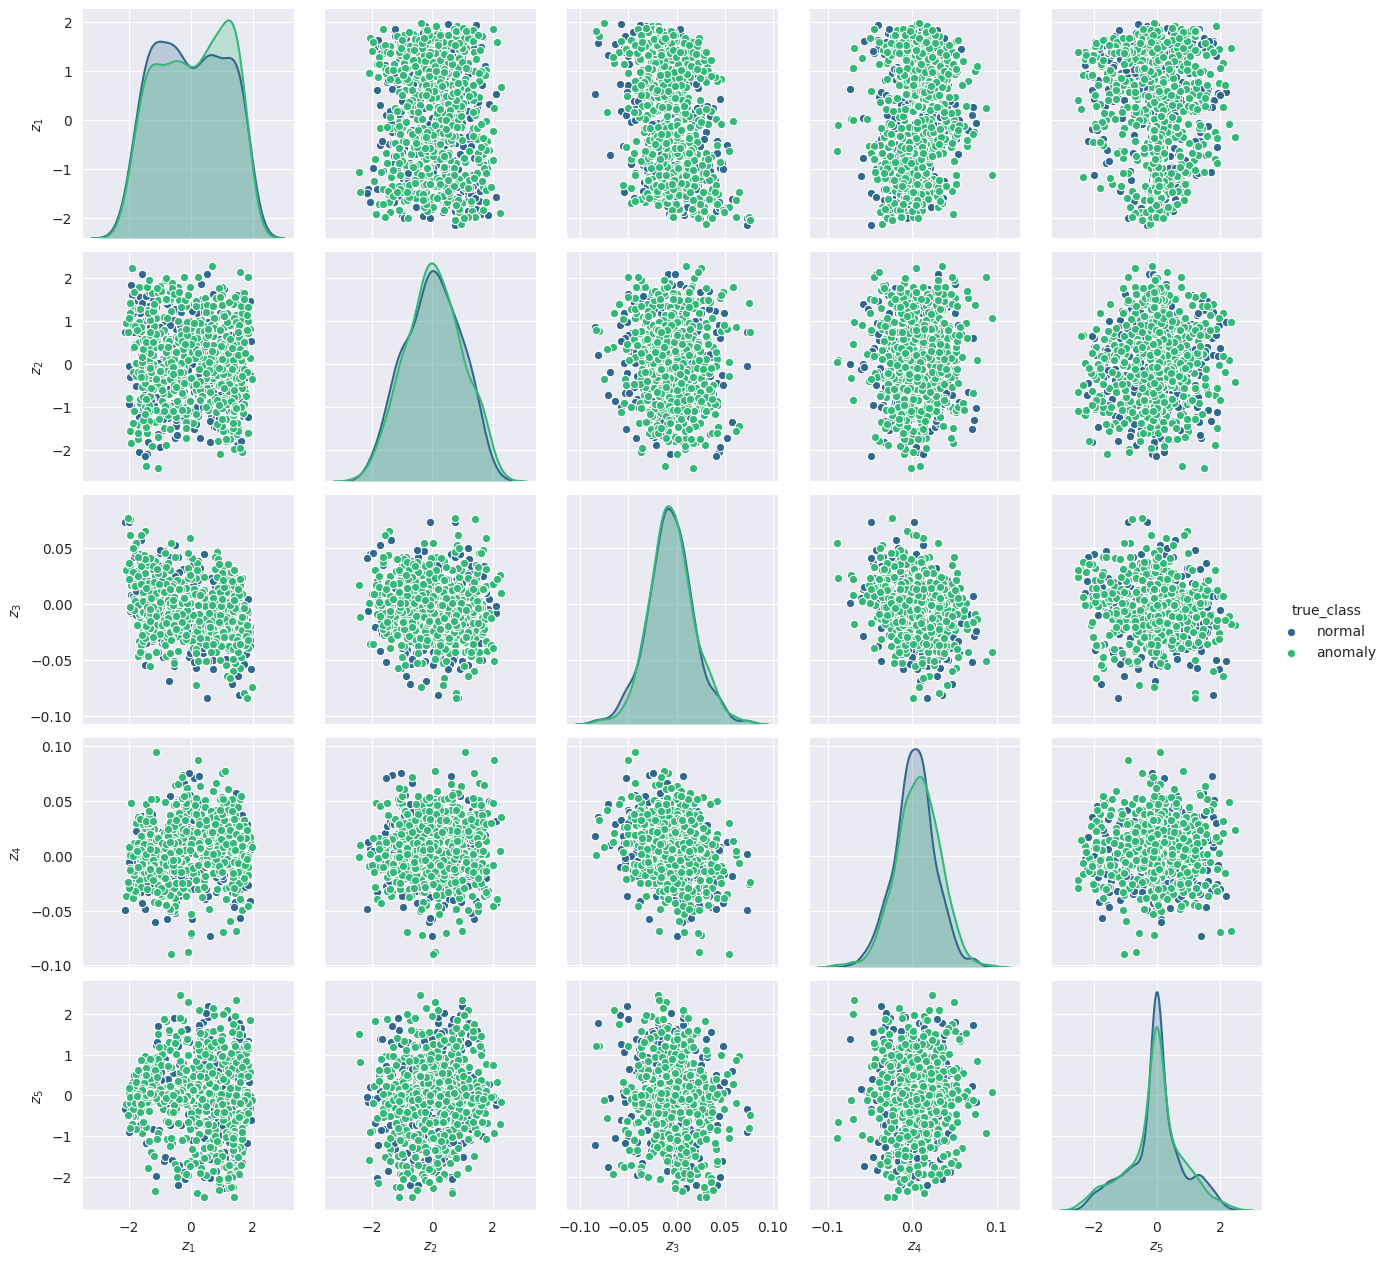

In [17]:
# display 2D manifold plots of the digit classes in the latent space (pairplot)
pairplot_latent(encoder, data)

#### Check distributions
Should be standard normal distributed.

*Histograms of the latent dimensions in the encoded space. Each dimension roughly follows a normal distribution."*

https://inside.edited.com/deep-learning-our-way-through-fashion-week-ea55bf50bab8


*Histogram of the learnt low-dimensional latent representations (first 16 components selected are shown). The codes in general follow a smooth and normal distribution which is important for the training of ACNN models.)*


Using FULL NORMAL dataset (train and test (and validation))

In [18]:
#FULLdataX = np.concatenate([trainX, testAllX], 0)
FULLNormalX = np.concatenate([trainX, testNormalX], 0)

In [19]:
def column(matrix, i):
    return [row[i] for row in matrix]

# get values in the encoded latent space (for each dimension)
#_, _, z_space = encoder.predict(trainX) 
#_, _, z_space = encoder.predict(FULLdataX) 
_, _, z_space = encoder.predict(FULLNormalX) 
z_space.shape

(1800, 8)

In [20]:
if latent_dim >= 16:
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True, sharey=True)
    
    axs = axs.ravel()
    for i in range(16):
        dim = pd.Series(column(z_space, i))
    
        dim.plot.hist(ax=axs[i], grid=True, stacked=True, density=True, bins=20, color='#607c8e')
        #sns.kdeplot(ax=axs[i], data=dim)
    
        # Density Plot and Histogram of all arrival delays
        #sns.distplot(dim, hist=True, kde=True, ax=axs[i], 
        #         bins=20, color='#607c8e', #'darkblue'
        #         hist_kws={'edgecolor':'darkblue'},
        #         kde_kws={'linewidth': 2})
    
        axs[i].set_title('Dimension {}'.format(i+1), fontsize=16)
        #axs[i].set_xticks([])                           # remove the x-axis tick labels
        axs[i].set(ylabel=None)                         # remove the y-axis label
        axs[i].tick_params(axis='both', which='major', labelsize=14)
    
  #  n = [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15]
  #  for j in n:
  #      axs[j].grid(True)
  #      axs[j].set_yticklabels([])
   #     #axs[j].set_yticks([])                          # remove the y-axis tick labels 
        
    fig.tight_layout()
    plt.show()
    
else:
    pass

In [21]:
if latent_dim >= 15:
    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 4), sharex=True, sharey=True)
    
    axs = axs.ravel()
    for i in range(15):
        dim = pd.Series(column(z_space, i))    
        dim.plot.hist(ax=axs[i], grid=True, stacked=True, density=True, bins=20, color='#607c8e')

        axs[i].set_title('Dimension {}'.format(i+1), fontsize=14)
        axs[i].set(ylabel=None) 
        axs[i].tick_params(axis='both', which='major', labelsize=12)
    
    fig.tight_layout()
    if (save_plots):
        plt.savefig(f"{FIGURES_FOLDER}/hist_learnedLatenet.png", dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    pass

### Encoder

#### Visualising Filters

*Inspect Learned Kernels (Encoder)*

In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

When Deep Learning folks talk about “filters” what they’re referring to is the learned weights of the convolutions. For example, a single 3x3 convolution is called a “filter” and that filter has a total of 10 weights (9 + 1 bias).

if we see a lot of zeros then we’ll know we have many dead filters that aren’t going much for our network.

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights.

In [22]:
# dictionary of the layers in the encoderm model; access the weights at each layer by the layer name:
layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
#layer_dict

In [23]:
# summarize filter shapes in each convolutional layer:
idx = []
for i in range(len(encoder.layers)):
    layer = encoder.layers[i]
    
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    idx.append(i)
    
    # get filter weights
    filters, biases = layer.get_weights()
    
    # summarize output shape
    print(i, layer.name,  filters.shape)

1 conv2d_1 (3, 3, 1, 32)
3 conv2d_2 (3, 3, 32, 32)
5 conv2d_3 (3, 3, 32, 32)
7 conv2d_4 (3, 3, 32, 32)
9 conv2d_5 (3, 3, 32, 32)


1th convolution layer:


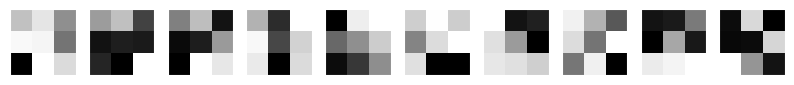

2th convolution layer:


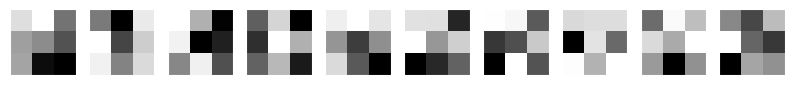

3th convolution layer:


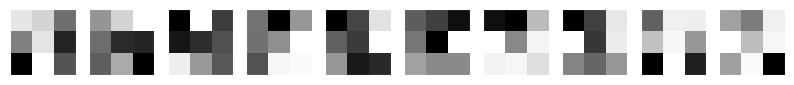

4th convolution layer:


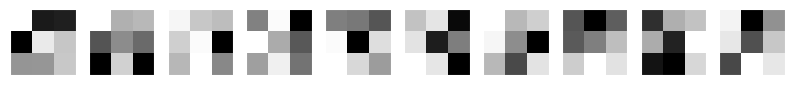

5th convolution layer:


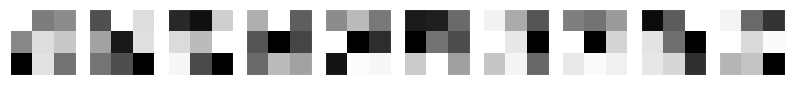

In [24]:
# normalize filter values to a range of 0 to 1 for better colormapping during plotting and visualization
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

# plot 10 filters from each convolution layers:
filtlayers = [1,2,3,4,5]
counter = 0
for i in range(len(idx)):
    # model.layers will print a list of layer parameters/values
    filters, biases = encoder.layers[idx[i]].get_weights()
    
    print('{}th convolution layer:'.format(filtlayers[counter]))
    fig, axs = plt.subplots(1,10, figsize=(10, 6))
    axs = axs.ravel()
    for i in range(10):
        axs[i].imshow(norm_filter(filters[:,:,0,i]), cmap=cm.Greys_r, vmin=0, vmax=1)
        axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
    plt.show()
    counter += 1

#### Visualising Feature Maps (Convolution Layers)


In [25]:
# summarize feature map size/shapes for each conv layer
idx = []
conv_names = []

for i in range(len(encoder.layers)):
    layer = encoder.layers[i]
    
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    idx.append(i)
    conv_names.append(layer.name)

    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d_1 (None, 64, 64, 32)
3 conv2d_2 (None, 32, 32, 32)
5 conv2d_3 (None, 16, 16, 32)
7 conv2d_4 (None, 8, 8, 32)
9 conv2d_5 (None, 4, 4, 32)


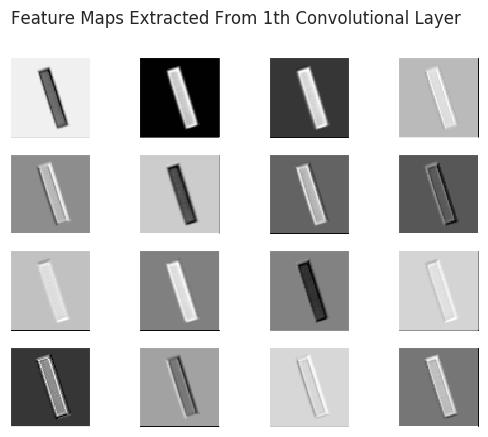

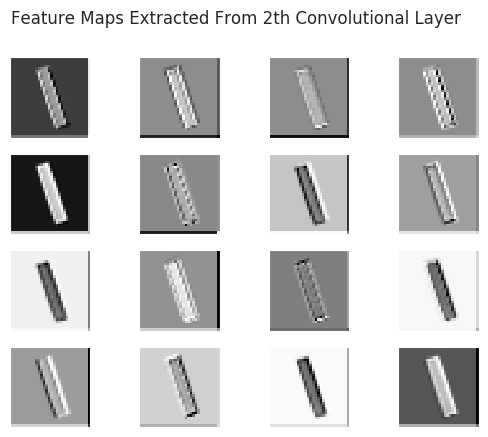

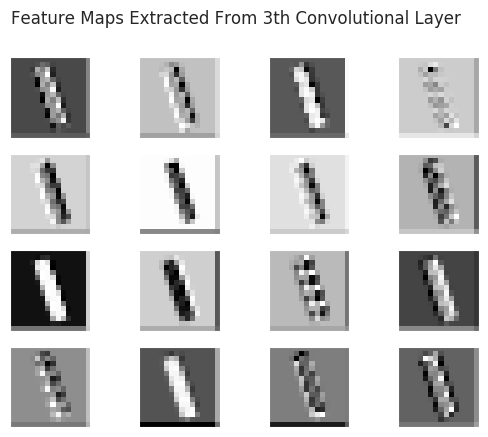

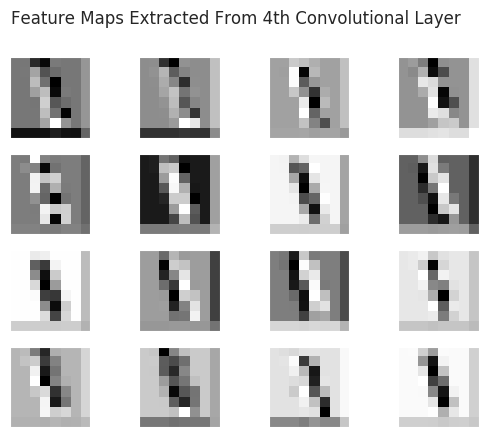

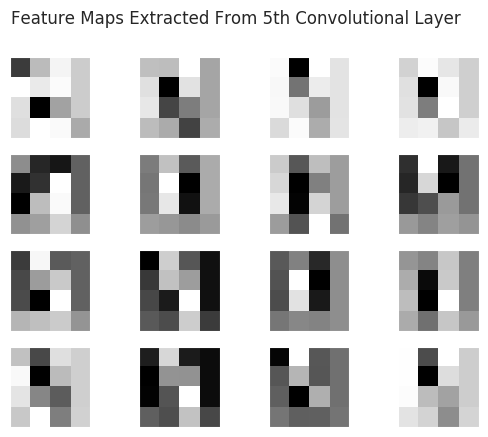

In [26]:
# redefine model to output all convolution layers:
conv_outputs = [encoder.layers[i].output for i in idx]        # convolutions
convolution_model = Model(inputs=encoder.inputs, outputs=conv_outputs)
#convolution_model.summary()

feature_maps = convolution_model.predict(np.expand_dims(trainX[0], axis=0)) #testGoodX[0]

# plot the output from each block
square = 4
convlayers = [1,2,3,4,5]     # used for titles..
counter = 0
for fmap in feature_maps:
    # plot 16 maps in an 4x4 squares
    ix = 1
    for i in range(square):
        for j in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            #plt.imshow(fmap[0, :, :, ix-1], cmap=cm.Greys_r, vmin=0, vmax=1)
            plt.imshow(fmap[0, :, :, ix-1], cmap=cm.Greys_r)  # "binary_r", 'viridis', 'plasma'
            ix += 1
    # show the figure
    plt.suptitle("Feature Maps Extracted From {}th Convolutional Layer".format(convlayers[counter]))
    #plt.tight_layout(pad=1, h_pad=0, w_pad=0)
    plt.show()
    counter += 1

#### Visualizing Intermediate Layer Activations (Activation Layers)

In [27]:
# summarize each activation layer:
adx = []
activ_names = []

for a in range(len(encoder.layers)):
    layer = encoder.layers[a]
    
    # check for convolutional layer
    if 'leaky_re_lu' not in layer.name:
        continue
    adx.append(a)
    activ_names.append(layer.name)

    # summarize output shape
    print(a, layer.name, layer.output.shape)

2 leaky_re_lu_1 (None, 64, 64, 32)
4 leaky_re_lu_2 (None, 32, 32, 32)
6 leaky_re_lu_3 (None, 16, 16, 32)
8 leaky_re_lu_4 (None, 8, 8, 32)
10 leaky_re_lu_5 (None, 4, 4, 32)
13 leaky_re_lu_6 (None, 200)


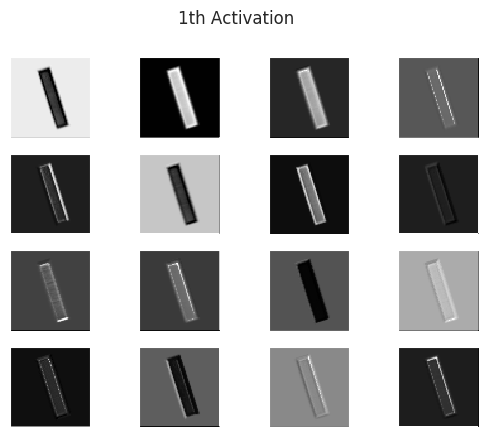

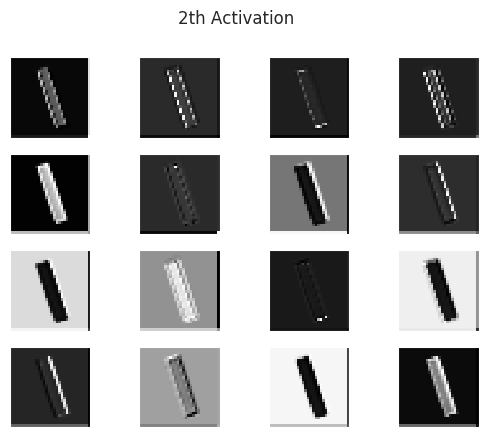

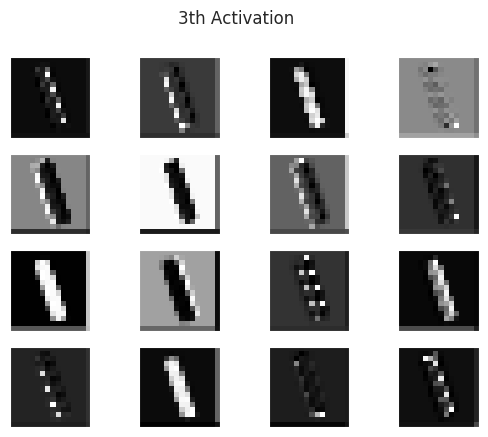

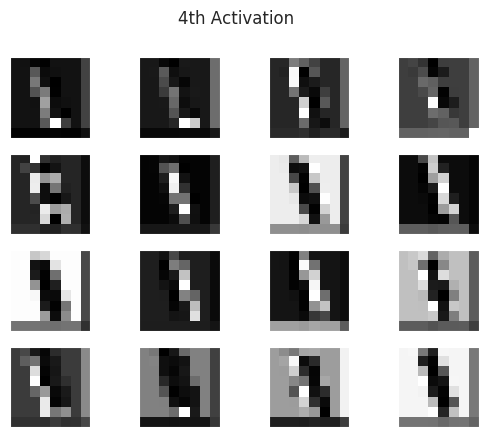

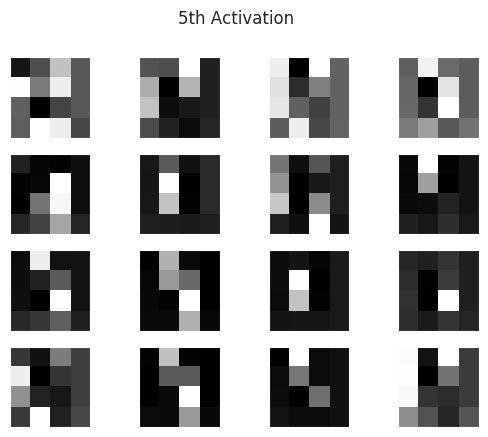

In [28]:
# redefine model to output all convolution layers:
activ_outputs = [encoder.layers[a].output for a in adx]       # activations
activation_model = Model(inputs=encoder.inputs, outputs=activ_outputs[:-1])
#activation_model.summary()

activations = activation_model.predict(np.expand_dims(trainX[0], axis=0)) #testGoodX[0]

# plot the output from each block
square = 4
actvlayers = [1,2,3,4,5]     # used for titles..
counter = 0
for fmap in activations:
    # plot 16 maps in an 4x4 squares
    ix = 1
    for i in range(square):
        for j in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap=cm.Greys_r)  # "binary_r", 'viridis', 'plasma'
            ix += 1
    # show the figure
    plt.suptitle("{}th Activation".format(actvlayers[counter]))
    #plt.tight_layout(pad=1, h_pad=0, w_pad=0)
    plt.show()
    counter += 1

### Decoder

Visualization of the 2 dimensional uniform manifold. 


In [29]:
def viz_decoded(encoder, decoder, data, num_channels=1):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                   j * img_height: (j + 1) * img_height] = digit
            
    plt.figure(figsize=(8, 8))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.grid(False)
  
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure, cmap=cm.Greys_r, vmin=0, vmax=1)
    plt.show()

In [30]:
if latent_dim == 2:
    viz_decoded(encoder, decoder, data, num_channels=1)
    
else:
    pass